In [100]:
import sys
import os
import struct
import time
import numpy as np
import gc
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import scipy

%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import learn_params_ridge_regression, get_predictions, get_value, set_value, Torch_fwRF_voxel_block, get_r2, add_nonlinearity, get_features_in_prf, get_fmaps_sizes
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

import gfb_utils as g
import nsd_utils as n


In [ ]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

In [98]:
# Loading a set of actual images

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

# Loading images to do some more testing...
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from src.load_nsd import image_uncolorize_fn

n_samples = 5000
trn_stim_data = image_uncolorize_fn(image_data)
trn_stim_data = trn_stim_data[ordering[0:n_samples]]

images = trn_stim_data


block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


In [101]:
# Parameters

# n_ori = 8
# n_sf = 3

n_ori = 36
n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
# First define the feature bank itself
freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
n_sd_out = 4

process_at_size = [227,227]

# This is the code i wrote to do gabor filtering, without any downsampling of images
# i.e. filter at their original resolutions
bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)


In [111]:
# This is the version of the filtering code that came from NSD OSF repository

from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import logspace

pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', padding_mode='circular',
          crop=False).to(device)

_fmaps_fn = _gaborizer
# _fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

# pull out some relevant stuff from gaborizer object to save
sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters    



In [112]:
# some params

n_images = 5000
sample_batch_size=2
n_batches = int(np.ceil(n_images/sample_batch_size))
n_pixels = process_at_size[0]
n_features = len(_gaborizer.orients_deg)*len(_gaborizer.cyc_per_stim)



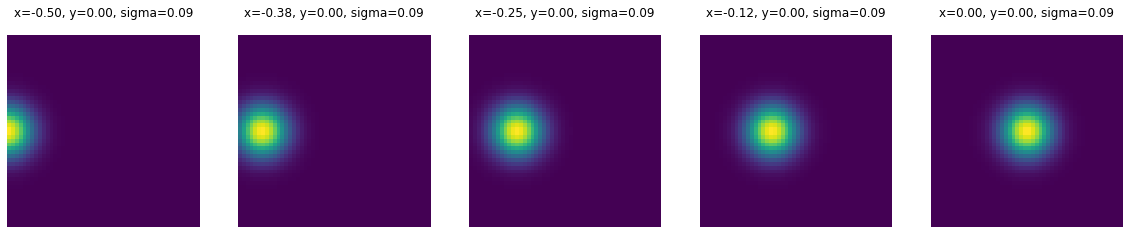

In [113]:
# define spatial RF region to use

# note get diff results for diff regions of space.

n_prfs = 5
xvals = np.linspace(-0.5, 0, 5)
yvals = 0*np.ones(np.shape(xvals))
sigmavals = 0.09*np.ones(np.shape(xvals))

from src.numpy_utility import make_gaussian_mass_stack

g = make_gaussian_mass_stack(xvals,yvals,sigmavals, n_pix=50, size=1.0, dtype=np.float32)
plt.figure(figsize=(20,4))
for mm in range(n_prfs):
    plt.subplot(1,5,mm+1)
    plt.pcolormesh(g[2][mm])
    plt.axis('equal')
    plt.axis('off')
    plt.title('x=%.2f, y=%.2f, sigma=%.2f'%(xvals[mm],yvals[mm],sigmavals[mm]))

In [114]:
# Get features for each desired pRF, across all trn set image 
sample_batch_size=50
n_features, fmaps_rez = get_fmaps_sizes(_fmaps_fn, torch.tensor(images[0:sample_batch_size]).to(device), device)

features_each_model = np.zeros((n_images, n_features, n_prfs))
for mm in range(n_prfs):
    features = get_features_in_prf((xvals[mm],yvals[mm],sigmavals[mm]), _fmaps_fn, images, sample_batch_size, aperture=1.0, device=device)
    features_each_model[:,:,mm] = features


/user_data/mmhender/imStat/fwrf_code_from_osf/src/torch_fwrf.py:235: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _x = torch.tensor(image_batch).to(device) # the input variable.
/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [115]:
# compute spatial average

# first get whole feature maps
t_start = time.time()
sample_batch_size=2
n_batches = int(np.ceil(n_images/sample_batch_size))

for bb in range(n_batches):
    
    image_range = np.arange(bb*sample_batch_size, min((bb+1)*sample_batch_size, n_images),1)

    t = time.time()
    
    fmaps = _fmaps_fn(_to_torch(images[image_range],device=device))

    elapsed = time.time() - t
    
    if bb==0:
        maps = [np.zeros(shape=(n_images, fm.shape[1], fm.shape[2], fm.shape[2])) for fm in fmaps]

    for sf in range(len(fmaps)):        
        maps[sf][image_range,:,:,:] = fmaps[sf].cpu().detach().numpy()
    
print(np.shape(maps[1]))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)

features_spat_average = np.zeros((n_images, n_features))
for sf in range(n_sf):
    
    features_spat_average[:,sf_tuning_masks[sf]==True] = np.mean(np.mean(maps[sf], axis=3), axis=2)
    
print(np.shape(features_spat_average))

g =(g[0], g[1],np.concatenate((g[2], np.zeros((1,np.shape(g[2])[2], np.shape(g[2])[2])) ), axis=0))
xvals = np.append(xvals,np.nan)
yvals = np.append(yvals,np.nan)
sigmavals = np.append(sigmavals,np.nan)

MemoryError: Unable to allocate 67.3 GiB for an array with shape (5000, 36, 224, 224) and data type float64

In [107]:
yvals = np.append(yvals,np.nan)
sigmavals = np.append(sigmavals,np.nan)

In [85]:
xvals

array([-0.5  , -0.375, -0.25 , -0.125,  0.   ,    nan])

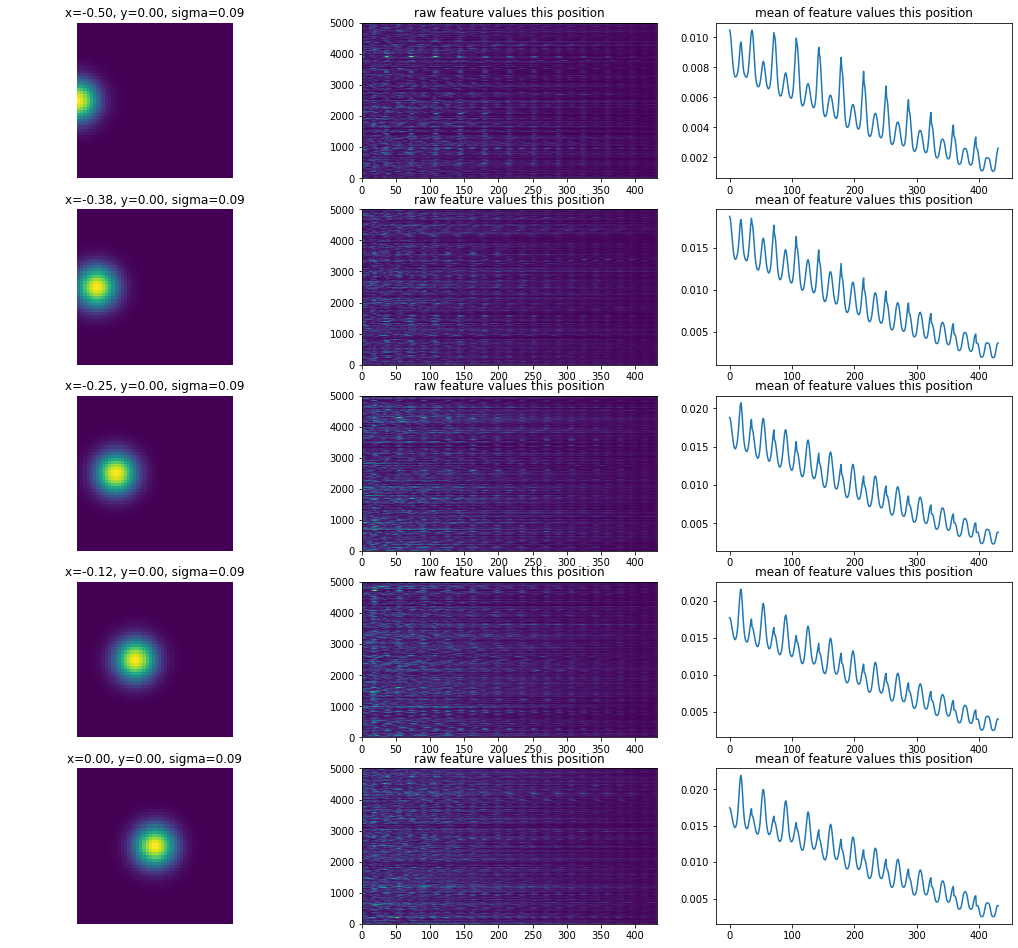

In [116]:
# Visualize the design matrix from these sets of features

plt.figure(figsize=(18,20));

for mm in range(n_prfs):
# for mm in range(n_prfs+1):
    
    plt.subplot(n_prfs+1,3,mm*3+1)
    plt.pcolormesh(g[2][mm])
    plt.axis('equal')
    plt.axis('off')
    if mm<n_prfs:
        plt.title('x=%.2f, y=%.2f, sigma=%.2f'%(xvals[mm],yvals[mm],sigmavals[mm]))
    else:
        plt.title('spatially averaged')
    plt.subplot(n_prfs+1,3,mm*3+2)
    if mm<n_prfs:
        features = features_each_model[:,:,mm]
    else:
        features = features_spat_average
    plt.pcolormesh(features)
    plt.title('raw feature values this position')
    
    plt.subplot(n_prfs+1,3,mm*3+3)
    plt.plot(np.mean(features, axis=0))
    plt.title('mean of feature values this position')


In [117]:
# PCA on each set of features

from sklearn import decomposition
import scipy

pca = decomposition.PCA()

scores = np.zeros((np.shape(features_each_model)[0],np.shape(features_each_model)[1],n_prfs) )
pca_wts = np.zeros((np.shape(features_each_model)[1],np.shape(features_each_model)[1],n_prfs) )
pct_expl_var = np.zeros((np.shape(features_each_model)[1],n_prfs) )

for mm in range(n_prfs):
    
    features = features_each_model[:,:,mm]
    print('running pca (original size %d by %d)'%(np.shape(features)[0],
                                              np.shape(features)[1]))
    
    pca.fit(features)
    scores[:,:,mm] = pca.transform(features)
    pca_wts[:,:,mm] = pca.components_
    pct_expl_var[:,mm] = pca.explained_variance_
    pct_expl_var[:,mm] = pct_expl_var[:,mm]/sum(pct_expl_var[:,mm])*100


running pca (original size 5000 by 432)
running pca (original size 5000 by 432)
running pca (original size 5000 by 432)
running pca (original size 5000 by 432)
running pca (original size 5000 by 432)


In [118]:
# PCA on each set of features

from sklearn import decomposition
import scipy

pca = decomposition.PCA()

features = features_spat_average
print('running pca (original size %d by %d)'%(np.shape(features)[0],
                                          np.shape(features)[1]))

pca.fit(features)
scores_spat_average = pca.transform(features)
pca_wts_spat_average = pca.components_
pct_expl_var_spat_average = pca.explained_variance_
pct_expl_var_spat_average = pct_expl_var_spat_average/sum(pct_expl_var_spat_average)*100


running pca (original size 5000 by 24)


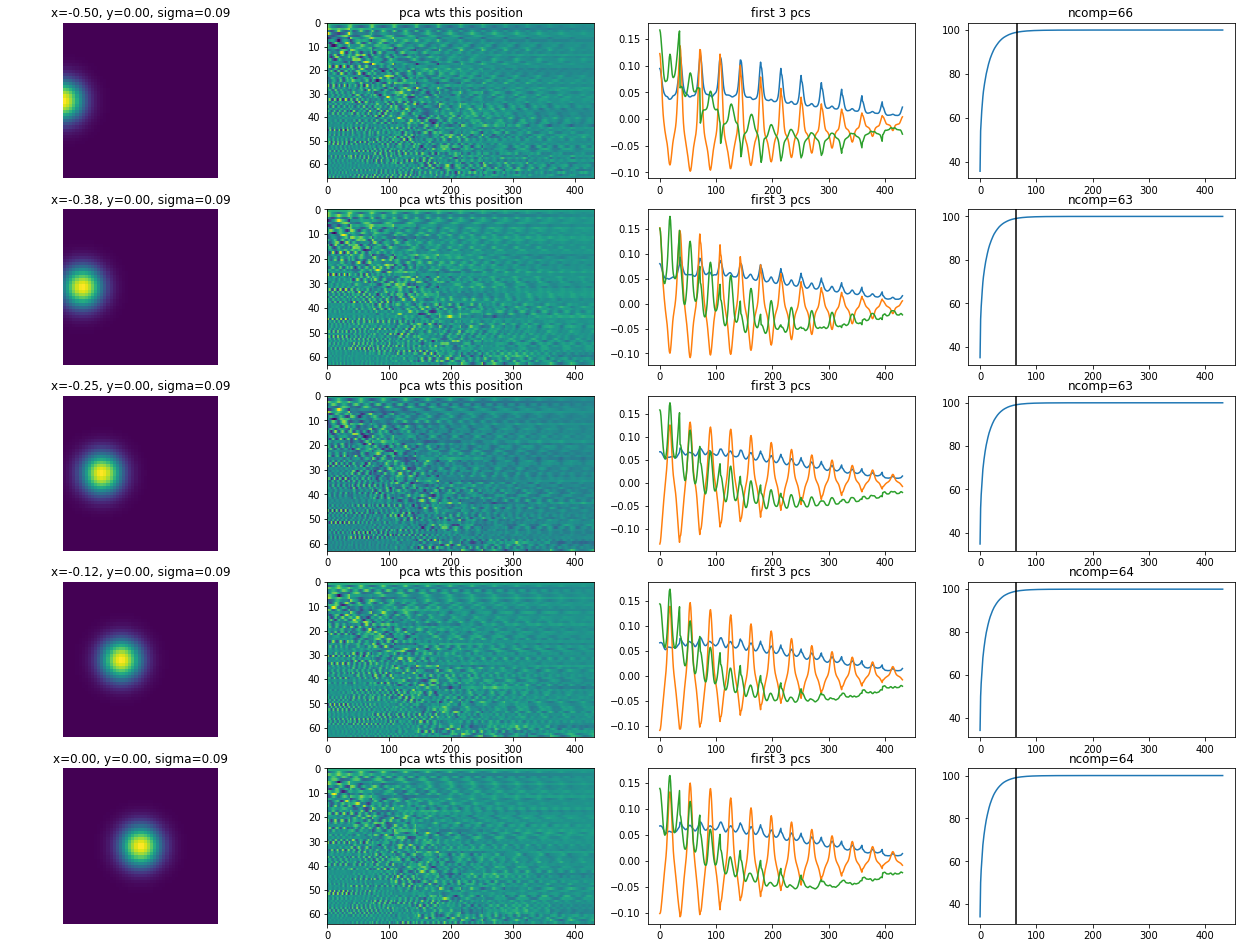

In [120]:
# Visualize the results of PCA for each spatial RF

plt.figure(figsize=(22,20));

npx=4
for mm in range(n_prfs):
# for mm in range(n_prfs+1):
    
    plt.subplot(n_prfs+1,npx,mm*npx+1)
    plt.pcolormesh(g[2][mm])
    plt.axis('equal')
    plt.axis('off')
    if mm<n_prfs:
        plt.title('x=%.2f, y=%.2f, sigma=%.2f'%(xvals[mm],yvals[mm],sigmavals[mm]))
    else:
        plt.title('spatially averaged')

    
    plt.subplot(n_prfs+1,npx,mm*npx+2)
    if mm<n_prfs:
        ncompneeded = np.where(np.cumsum(pct_expl_var[:,mm])>99)[0][0]
        features = pca_wts[0:ncompneeded,:,mm]
        pv = pct_expl_var[:,mm]
    else:
        ncompneeded = np.where(np.cumsum(pct_expl_var_spat_average)>99)[0][0]
        features = pca_wts_spat_average[0:ncompneeded,:]
        pv = pct_expl_var_spat_average
        
    plt.pcolormesh(features)
    plt.title('pca wts this position')
    plt.gca().invert_yaxis()

    plt.subplot(n_prfs+1,npx,mm*npx+3)
    plt.plot(np.transpose(features[0:3,:]))
    plt.title('first 3 pcs')
    
    plt.subplot(n_prfs+1,npx,mm*npx+4)   
    plt.plot(np.cumsum(pv))
    plt.axvline(ncompneeded,color='k')
    plt.title('ncomp=%d'%ncompneeded)


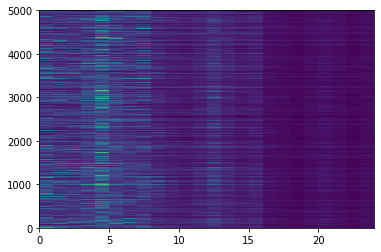

In [56]:
plt.figure();
plt.pcolormesh(features_spat_average)

In [45]:
# PCA on each set of features

from sklearn import decomposition
import scipy

pca = decomposition.PCA()

scores = np.zeros((np.shape(features_each_model)[0],np.shape(features_each_model)[1],n_prfs) )
pca_wts = np.zeros((np.shape(features_each_model)[1],np.shape(features_each_model)[1],n_prfs) )
pct_expl_var = np.zeros((np.shape(features_each_model)[1],n_prfs) )

for mm in range(n_prfs):
    
    features = features_each_model[:,:,mm]
    print('running pca (original size %d by %d)'%(np.shape(features)[0],
                                              np.shape(features)[1]))
    
    pca.fit(features)
    scores[:,:,mm] = pca.transform(features)
    pca_wts[:,:,mm] = pca.components_
    pct_expl_var[:,mm] = pca.explained_variance_
    pct_expl_var[:,mm] = pct_expl_var[:,mm]/sum(pct_expl_var[:,mm])*100


running pca (original size 5000 by 24)
running pca (original size 5000 by 24)
running pca (original size 5000 by 24)
running pca (original size 5000 by 24)
running pca (original size 5000 by 24)
